# Rozpoznawanie monet po wielkości i kolorze

Klasyfikacja polskich monet na podstawie cech klasycznych (wielkość, kolor) z detekcją obcych monet/żetonów.

## 1. Import bibliotek

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

## 2. Detekcja monety na obrazie

In [14]:
def find_coin(image):
    """
    Znajduje monetę na obrazie za pomocą detekcji krawędzi.
    Zwraca: (x, y, radius) lub None.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 100)
    
    kernel = np.ones((5, 5), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=2)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None
    
    best = None
    best_area = 0
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 5000:
            continue
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * area / (perimeter ** 2)
        if circularity > 0.4 and area > best_area:
            best_area = area
            best = cnt
    
    if best is None:
        best = max(contours, key=cv2.contourArea)
    
    (x, y), radius = cv2.minEnclosingCircle(best)
    return (int(x), int(y), int(radius))

## 3. Ekstrakcja cech

In [15]:
FEATURE_NAMES = [
    'diameter',
    'mean_r', 'mean_g', 'mean_b',
    'std_r', 'std_g', 'std_b',
    'mean_h', 'mean_s', 'mean_v',
    'gold_ratio', 'brightness'
]

def extract_features(image):
    """
    Ekstrahuje cechy wielkości i koloru z obrazu monety.
    Zwraca wektor 12 cech.
    """
    h, w = image.shape[:2]
    coin = find_coin(image)
    
    if coin is None:
        x, y = w // 2, h // 2
        radius = min(h, w) // 4
    else:
        x, y, radius = coin
    
    # Wielkość znormalizowana
    diameter = (radius * 2) / max(h, w)
    
    # Maska wewnętrznej części monety
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, (x, y), int(radius * 0.7), 255, -1)
    
    pixels = image[mask > 0]
    
    if len(pixels) < 100:
        cy, cx = h // 2, w // 2
        r = min(h, w) // 4
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(mask, (cx, cy), r, 255, -1)
        pixels = image[mask > 0]
    
    # Cechy RGB
    mean_r = np.mean(pixels[:, 0]) / 255
    mean_g = np.mean(pixels[:, 1]) / 255
    mean_b = np.mean(pixels[:, 2]) / 255
    std_r = np.std(pixels[:, 0]) / 255
    std_g = np.std(pixels[:, 1]) / 255
    std_b = np.std(pixels[:, 2]) / 255
    
    # Cechy HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_pixels = hsv[mask > 0]
    mean_h = np.mean(hsv_pixels[:, 0]) / 180
    mean_s = np.mean(hsv_pixels[:, 1]) / 255
    mean_v = np.mean(hsv_pixels[:, 2]) / 255
    
    # Wskaźniki koloru
    gold_ratio = mean_r / (mean_b + 0.001)
    brightness = (mean_r + mean_g + mean_b) / 3
    
    return np.array([
        diameter,
        mean_r, mean_g, mean_b,
        std_r, std_g, std_b,
        mean_h, mean_s, mean_v,
        gold_ratio, brightness
    ])

## 4. Wczytywanie datasetu

In [16]:
def load_dataset(data_dir):
    """
    Wczytuje obrazy z folderu i ekstrahuje cechy.
    Struktura: data_dir/klasa/obrazy.jpg
    """
    X = []
    y = []
    
    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        count = 0
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    X.append(extract_features(img))
                    y.append(class_name)
                    count += 1
        
        print(f"  {class_name}: {count}")
    
    return np.array(X), y

## 5. Klasyfikator z detekcją anomalii

In [17]:
def classify_with_anomaly_detection(X_train, y_train, X_test, prob_thresh=0.5, iso_contam=0.03):
    """
    Klasyfikacja z detekcją obcych monet.
    Łączy SVM (próg pewności) z Isolation Forest.
    Moneta oznaczana jako 'wrong' gdy OBA detektory wskazują anomalię.
    """
    # Klasyfikator SVM z prawdopodobieństwem
    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    
    proba = svm.predict_proba(X_test)
    max_proba = np.max(proba, axis=1)
    svm_pred = svm.predict(X_test)
    
    # Detektor anomalii
    iso = IsolationForest(contamination=iso_contam, random_state=42)
    iso.fit(X_train)
    iso_pred = iso.predict(X_test)
    
    # Kombinacja: wrong jeśli OBA mówią anomalia
    predictions = []
    for i in range(len(X_test)):
        svm_uncertain = max_proba[i] < prob_thresh
        iso_anomaly = iso_pred[i] == -1
        
        if svm_uncertain and iso_anomaly:
            predictions.append('wrong')
        else:
            predictions.append(svm_pred[i])
    
    return predictions, svm, iso

## 6. Wizualizacja wyników

In [18]:
def plot_results(y_true, y_pred):
    """
    Wyświetla macierz pomyłek i raport klasyfikacji.
    """
    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    acc = accuracy_score(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Macierz pomyłek (dokładność: {acc*100:.2f}%)')
    plt.ylabel('Prawdziwa klasa')
    plt.xlabel('Przewidziana klasa')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\nDokładność: {acc*100:.2f}%")
    print("\nRaport klasyfikacji:")
    print(classification_report(y_true, y_pred))

---
## 7. Uruchomienie

In [19]:
DATASET_PATH = "dataset"

In [20]:
print("Wczytywanie danych treningowych...")
X_train, y_train = load_dataset(os.path.join(DATASET_PATH, "train"))
print(f"Razem: {len(X_train)} obrazów, {len(FEATURE_NAMES)} cech\n")

print("Wczytywanie danych testowych...")
X_test, y_test = load_dataset(os.path.join(DATASET_PATH, "test"))
print(f"Razem: {len(X_test)} obrazów")

Wczytywanie danych treningowych...
  10gr: 20
  1gr: 20
  1zl: 20
  20gr: 20
  2gr: 20
  2zl: 20
  50gr: 20
  5gr: 20
  5zl: 20
Razem: 180 obrazów, 12 cech

Wczytywanie danych testowych...
  10gr: 20
  1gr: 20
  1zl: 20
  20gr: 20
  2gr: 20
  2zl: 20
  50gr: 20
  5gr: 20
  5zl: 20
  wrong: 8
Razem: 188 obrazów


In [21]:
# Skalowanie cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Klasyfikacja
y_pred, svm_model, iso_model = classify_with_anomaly_detection(
    X_train_scaled, y_train, X_test_scaled,
    prob_thresh=0.6,
    iso_contam=0.03
)

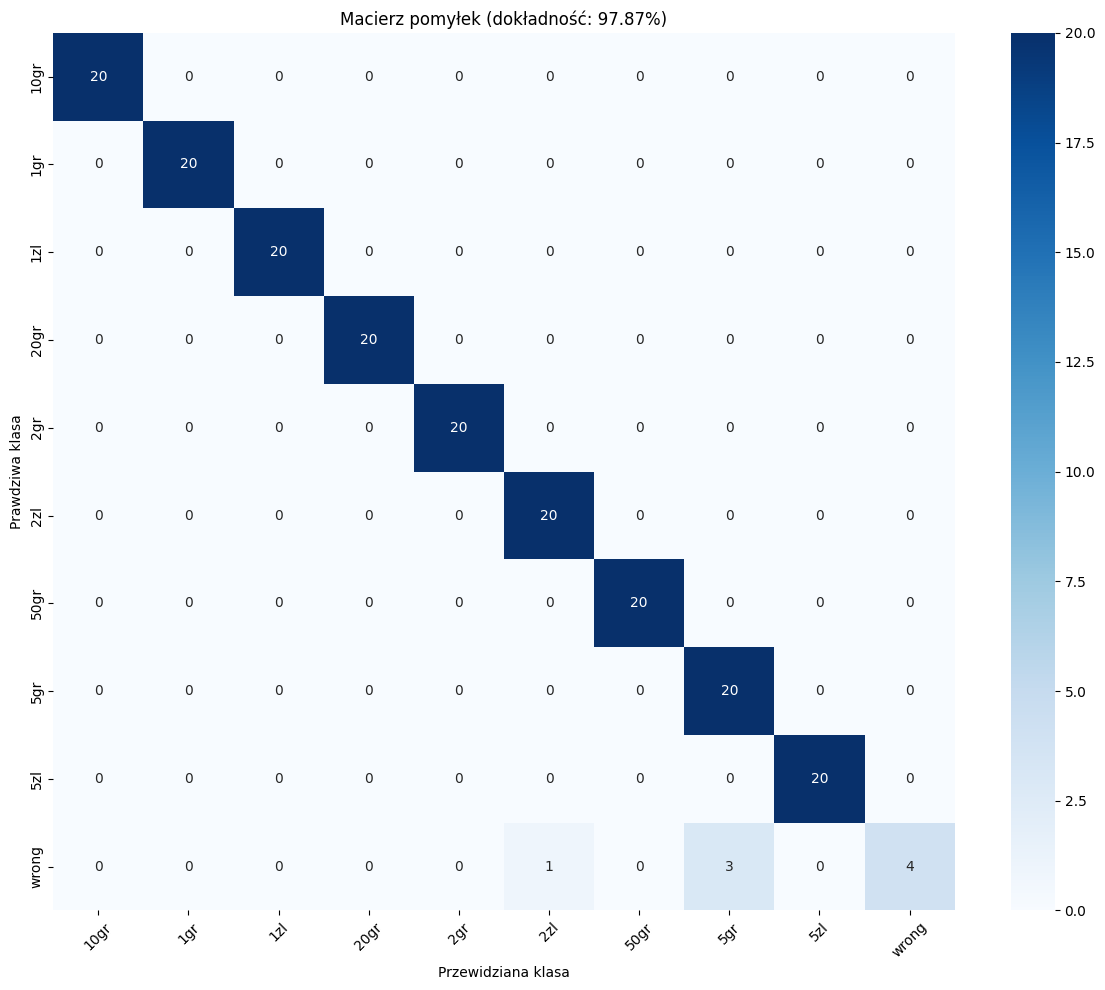


Dokładność: 97.87%

Raport klasyfikacji:
              precision    recall  f1-score   support

        10gr       1.00      1.00      1.00        20
         1gr       1.00      1.00      1.00        20
         1zl       1.00      1.00      1.00        20
        20gr       1.00      1.00      1.00        20
         2gr       1.00      1.00      1.00        20
         2zl       0.95      1.00      0.98        20
        50gr       1.00      1.00      1.00        20
         5gr       0.87      1.00      0.93        20
         5zl       1.00      1.00      1.00        20
       wrong       1.00      0.50      0.67         8

    accuracy                           0.98       188
   macro avg       0.98      0.95      0.96       188
weighted avg       0.98      0.98      0.98       188



In [23]:
# Wyniki
plot_results(y_test, y_pred)

---
## 8. Klasyfikacja pojedynczego obrazu

In [24]:
def classify_single_image(image_path, svm_model, iso_model, scaler, prob_thresh=0.5):
    """
    Klasyfikuje pojedynczy obraz monety.
    """
    img = cv2.imread(image_path)
    if img is None:
        return None, 0
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    features = extract_features(img).reshape(1, -1)
    features_scaled = scaler.transform(features)
    
    proba = svm_model.predict_proba(features_scaled)
    max_proba = np.max(proba)
    svm_pred = svm_model.predict(features_scaled)[0]
    iso_pred = iso_model.predict(features_scaled)[0]
    
    if max_proba < prob_thresh and iso_pred == -1:
        return 'wrong', max_proba
    else:
        return svm_pred, max_proba